In [1]:
import re, sys, math, json, os, urllib.request
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 

try:
  model_data = pd.read_json('data.json',
                        lines=True,
                        orient='columns')
  glove_file = open('glove.6B.100d.txt', encoding = "utf8")
  print('Glove loaded.')
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Glove loaded.
Success: Data loaded into dataframe.


In [2]:
raw_data = model_data
raw_data

content  \
0                                               an,title   
1      STARKY0020180125ee1o0001i,Raila has crossed th...   
2      MTPW000020180409ee4900899,Political risk remai...   
3      AFNWS00020171114edbe0018o,You Can Still Have Y...   
4      JMATH00020171219edcj0008f,Fuzzy Logic; Studies...   
...                                                  ...   
14450  DALYIG0020171214edce000jw,"Nigeria Spends N43t...   
14451  SNLMMDW020171214edcd0000b,Intrepid Mines selli...   
14452  DJDN000020171211edcb001dd,Global Commodities R...   
14453  BUSIDA0020180403ee4300003,"Equity, Stanbic top...   
14454  ICROWDN020180226ee2q0008f,"Solar Glass Market ...   

                                     annotation  extras  \
0               {'labels': ['N/A'], 'note': ''}     NaN   
1               {'labels': ['N/A'], 'note': ''}     NaN   
2               {'labels': ['N/A'], 'note': ''}     NaN   
3               {'labels': ['N/A'], 'note': ''}     NaN   
4               {'labels': ['N/A'], 'note': ''}     NaN   
...                                         ...     ...   
14450  {'labels': ['Not Distress'], 'note': ''}     NaN   
14451  {'labels': ['Not Distress'], 'note': ''}     NaN   
14452  {'labels': ['Not Distress'], 'note': ''}     NaN   
14453  {'labels': ['Not Distress'], 'note': ''}     NaN   
14454  {'labels': ['Not Distress'], 'note': ''}     NaN   

                                                metadata  
0      {'first_done_at': 1529677325000, 'last_updated...  
1      {'first_done_at': 1529758904000, 'last_updated...  
2      {'first_done_at': 1529688087000, 'last_updated...  
3      {'first_done_at': 1529587470000, 'last_updated...  
4      {'first_done_at': 1529659936000, 'last_updated...  
...                                                  ...  
14450  {'first_done_at': 1529646472000, 'last_updated...  
14451  {'first_done_at': 1529670790000, 'last_updated...  
14452  {'first_done_at': 1529669474000, 'last_updated...  
14453  {'first_done_at': 1529601535000, 'last_updated...  
14454  {'first_done_at': 1529589340000, 'last_updated...  

[14455 rows x 4 columns]

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import keras
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.
/Users/karolinabogacka/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/karolinabogacka/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/karolinabogacka/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/karolinabogacka/

In [4]:
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from string import punctuation
from collections import Counter
import numpy as np

def pad_dict_list(dict_list, padel):
    lmax = 0
    length = len(dict_list)
    for lname in dict_list:
        lmax = max(lmax, len(lname))
    for i in range(0, length):
        ll = len(dict_list[i])
        if ll < lmax:
            dict_list[i].append(padel)   
    return dict_list

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

titles = [re.split("^(.+?),", title)[-1] for title in raw_data.content]
X = []
for sen in titles:
    X.append(preprocess_text(sen))
titles = [title.lower() for title in X]
titles = [''.join([c for c in title if c not in punctuation]) for title in titles]
labels = [md['labels'] for md in raw_data.annotation]

labels2 = []

for i in range(0, len(labels)):
    if i:
        labels2.append(labels[i])
    else:
        titles.pop(i)
        
labels = labels2

distressed_labels = []
not_distressed_labels = []
na_labels = []

for label in labels:
    if "Distress" in label:
        distressed_labels.append(1)
    else:
        distressed_labels.append(0)
        
    if "Not Distress" in label: 
        not_distressed_labels.append(1)
    else:
        not_distressed_labels.append(0)
        
    if "N/A" in label:
        na_labels.append(1)
    else:
        na_labels.append(0)


encoded_labels = np.array(np.column_stack((distressed_labels, not_distressed_labels, na_labels)))

X_train, X_test, y_train, y_test = train_test_split(titles, encoded_labels, test_size=0.20, random_state=42)
encoded_labels

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [5]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [6]:
max_len = max([len(i) for i in X_train])
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding='post', maxlen = max_len)
X_test = pad_sequences(X_test, padding='post', maxlen = max_len)

In [7]:
try:
  glove_file = open('glove.6B.100d.txt', encoding = "utf8")
  print('Glove loaded.')
except Exception as e:
    print('Data load error: ',e)

Glove loaded.


In [8]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [9]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [10]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
deep_inputs = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, 100, weights = [embedding_matrix], trainable= False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(3, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs = dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 42)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 42, 100)           1459700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,577,335
Trainable params: 117,635
Non-trainable params: 1,459,700
_________________________________________________________________
None


In [12]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Train on 9250 samples, validate on 2313 samples
Epoch 1/6
9250/9250 [==============================] - 20s 2ms/step - loss: 0.5808 - acc: 0.6808 - val_loss: 0.5660 - val_acc: 0.6873
Epoch 2/6
9250/9250 [==============================] - 19s 2ms/step - loss: 0.5371 - acc: 0.7298 - val_loss: 0.5021 - val_acc: 0.7789
Epoch 3/6
9250/9250 [==============================] - 18s 2ms/step - loss: 0.5287 - acc: 0.7311 - val_loss: 0.5387 - val_acc: 0.7325
Epoch 4/6
9250/9250 [==============================] - 18s 2ms/step - loss: 0.5210 - acc: 0.7548 - val_loss: 0.5014 - val_acc: 0.7782
Epoch 5/6
9250/9250 [==============================] - 18s 2ms/step - loss: 0.5140 - acc: 0.7516 - val_loss: 0.5629 - val_acc: 0.6873
Epoch 6/6
9250/9250 [==============================] - 18s 2ms/step - loss: 0.5665 - acc: 0.6800 - val_loss: 0.5657 - val_acc: 0.6876


In [13]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

2891/2891 [==============================] - 3s 1ms/step
Test Score: 0.5652282742202921
Test Accuracy: 0.6885737776756287


In [14]:
model.save('models2.h5')

In [15]:
import pickle
 
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
loaded_model = load_model('model_dir/models1.h5')
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 42)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 42, 100)           1459700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,577,335
Trainable params: 117,635
Non-trainable params: 1,459,700
_________________________________________________________________


In [107]:
score = loaded_model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

2891/2891 [==============================] - 4s 1ms/step
Test Score: 0.4253945680214682
Test Accuracy: 0.8208231329917908


In [60]:
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)
txt="House of Representatives Investigate Arcelor Mittal Bad Labor Practices Allegation"
seq= loaded_tokenizer.texts_to_sequences([txt])
padded = pad_sequences(seq, maxlen=max_len)
pred = loaded_model.predict(padded)
print(pred)

[[0.20884761 0.19528437 0.7951047 ]]


In [62]:
if round(pred[0][0])==1:
    distress = 1
elif round(pred[0][2])==1:
    distress = -1
elif round(pred[0][1])==1:
    distress = 0
distress

-1

In [16]:
import os
import collections
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

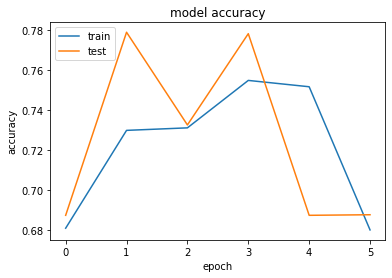

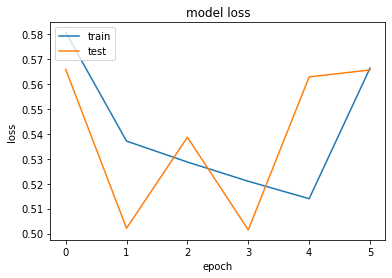

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [24]:
y_train

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

In [26]:
import numpy as np
from sklearn.metrics import label_ranking_average_precision_score

def zero_rule_algorithm(train_df, eval_df):
    outputs = [tuple(t) for t in train_df]
    most_common = max(outputs, key = outputs.count)
    return [most_common for i in range(len(eval_df))]
    
predictions = zero_rule_algorithm(y_train, y_test)
values = [tuple(i) for i in y_test]
label_ranking_average_precision_score(values, predictions)

0.6890925861870033